In [42]:
#Before running the notebook, run this cell to import all the functions
import sys as SYS; SYS.path.insert(0, '..')
import os

from collections import defaultdict
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt

from src import setup
# setup.use_gpu()

from src import ( 
    measurements as measure,
    density_matrix as DM,
    simulation as sim,
    orders,
    order_rules,
    random_unitary,
    simulation)

from Scripts import simulation_CLI as cleo
import networkx as nx
import itertools
from itertools import combinations

In [43]:
def find_connected_pairs(adjacency_matrix):
    connected_pairs = []
    num_nodes = len(adjacency_matrix)

    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):  # Ensure we only consider distinct pairs
            if adjacency_matrix[i][j] == 1:  # If there's a connection between nodes i and j
                connected_pairs.append([i, j])  # Use a list [i, j] instead of a tuple (i, j)

    return connected_pairs

def find_two_node_subgroups(adjacency_matrix, num_pairs):
    connected_pairs = find_connected_pairs(adjacency_matrix)
    num_nodes = len(adjacency_matrix)
    
    all_subgroups = []
    
    def is_valid(curr_pair):
        nodes = [node for pair in curr_pair for node in pair]
        return len(set(nodes)) == num_nodes
    
    def backtrack(curr_pair, remaining_pairs):
        if len(curr_pair) == num_pairs:
            sorted_curr_pair = sorted(curr_pair)
            if is_valid(sorted_curr_pair):
                all_subgroups.append(sorted_curr_pair)
            return
        
        for pair in remaining_pairs:
            if all(node not in [n for p in curr_pair for n in p] for node in pair):
                curr_pair.append(pair)
                next_pairs = [p for p in remaining_pairs if p != pair]
                backtrack(curr_pair, next_pairs)
                curr_pair.pop()
    
    backtrack([], connected_pairs)
    
    # Remove duplicates
    unique_subgroups = {frozenset(map(tuple, subgroup)) for subgroup in all_subgroups}
    unique_subgroups = [list(map(list, subgroup)) for subgroup in unique_subgroups]
    
    # Convert the result to a list of np.array
    unique_subgroups_np = [np.array(subgroup) for subgroup in unique_subgroups]
    
    return unique_subgroups_np

# Function to plot the adjacency matrix
def plot_adjacency_matrix(adjacency_matrix):
    plt.figure(figsize=(8, 8))
    plt.imshow(adjacency_matrix, cmap='binary', interpolation='none')
    plt.title('Adjacency Matrix')
    plt.xlabel('Node Index')
    plt.ylabel('Node Index')
    plt.colorbar()
    plt.show()

def plot_chosen_pairs(adjacency_matrix, chosen_pairs):
    plt.figure(figsize=(8, 8))
    plt.imshow(adjacency_matrix, cmap='binary', interpolation='none')
    plt.title('Adjacency Matrix with Chosen Pairs')
    plt.xlabel('Node Index')
    plt.ylabel('Node Index')
    
    # Plot chosen pairs
    for pair in chosen_pairs:
        plt.plot(pair, pair, color='red')  # Plot each pair
        
    plt.colorbar()
    plt.show()

def plot_network_graph(adjacency_matrix):
    G = nx.Graph()
    num_nodes = len(adjacency_matrix)
    
    # Add edges based on the adjacency matrix
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if adjacency_matrix[i][j] == 1:
                G.add_edge(i, j)
    
    pos = nx.circular_layout(G)  # Positions for all nodes
    
    plt.figure(figsize=(12, 12))
    nx.draw(G, pos, with_labels=True, node_color='lightblue',edge_color="gray", node_size=1000,  width=3,font_size=12)
    plt.title('Network Graph')
    plt.show()

# Function to plot the network graph with highlighted pairs
def plot_network_graph_with_highlight(adjacency_matrix, chosen_pairs):
    G = nx.Graph()
    num_nodes = len(adjacency_matrix)
    
    # Add edges based on the adjacency matrix
    for i in range(num_nodes):
        for j in range(i+1, num_nodes):
            if adjacency_matrix[i][j] == 1:
                G.add_edge(i, j)
    
    pos = nx.circular_layout(G)  # Positions for all nodes
    
    plt.figure(figsize=(8, 8))
    
    # Draw nodes and edges
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, font_size=12)
    
    # Highlight chosen pairs
    for pair in chosen_pairs:
        nx.draw_networkx_edges(G, pos, edgelist=[pair], width=2, edge_color='orange')
        nx.draw_networkx_nodes(G, pos, nodelist=pair, node_color='lightblue', node_size=1000)
    
    plt.title('Network Graph with Highlighted Pairs')
    plt.show()

In [48]:
#Code to generate number of random qubit pairings...Note that this code can take time in n=number of nodes is larger than 10.
n=12
def generate_pairs(objects):
    if len(objects) % 2 != 0:
        raise ValueError("Number of objects must be even to form pairs.")
    
    # Generate all possible pairs of objects
    pairs = list(itertools.combinations(objects, 2))
    
    # Function to check if a set of pairs is valid (no overlapping objects)
    def is_valid_combination(pair_comb):
        seen = set()
        for pair in pair_comb:
            if pair[0] in seen or pair[1] in seen:
                return False
            seen.update(pair)
        return True
    
    # Generate all unique combinations of pairs
    pair_combinations = list(itertools.combinations(pairs, len(objects) // 2))
    
    # Filter valid combinations
    valid_combinations = [comb for comb in pair_combinations if is_valid_combination(comb)]
    
    # Convert each combination to a numpy array of lists
    valid_combinations = [np.array([list(pair) for pair in comb]) for comb in valid_combinations]
    
    return valid_combinations

Unique subgroups of pairs as np.array:
[array([[0, 1],
       [2, 3]])]


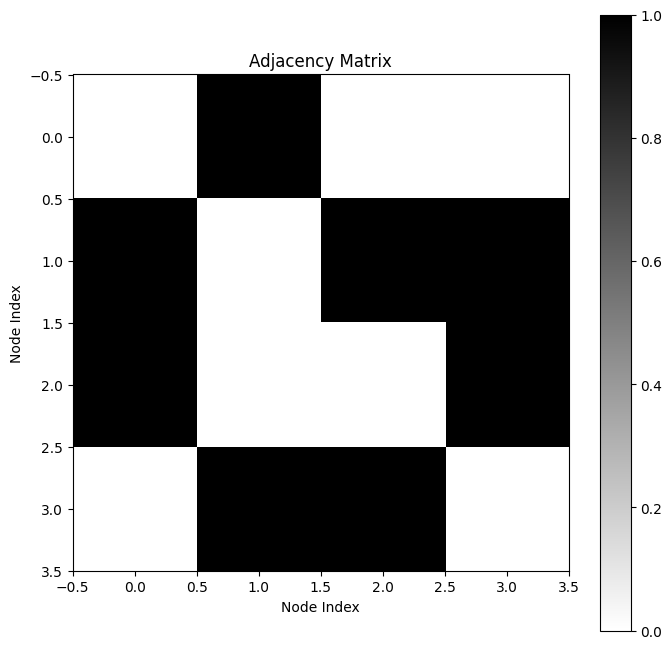

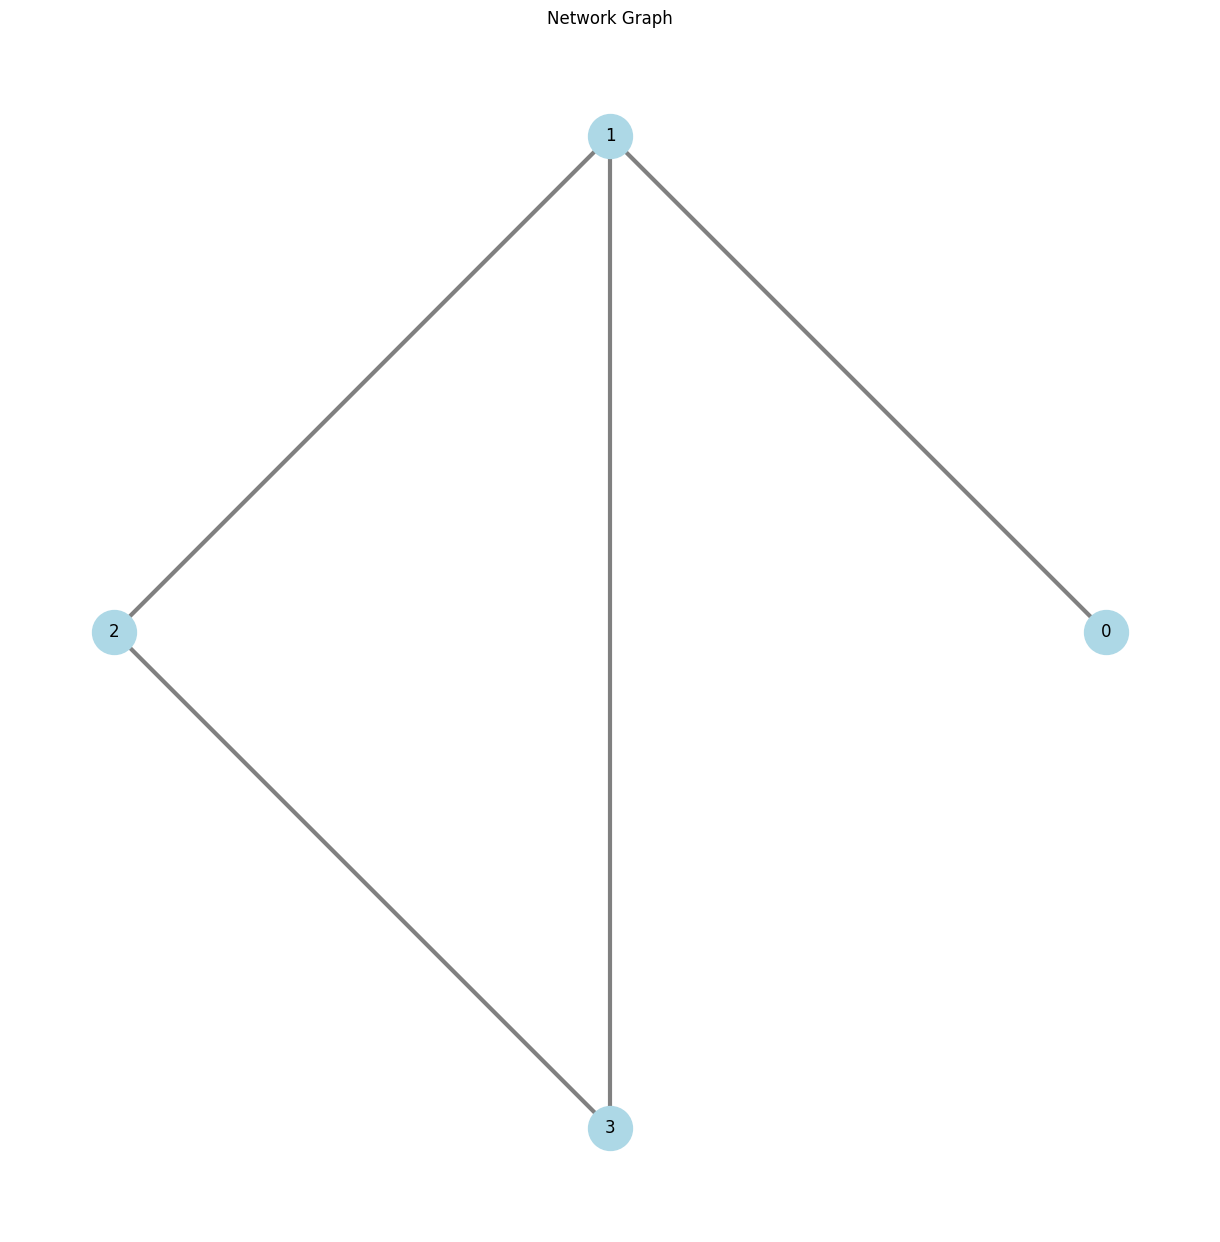

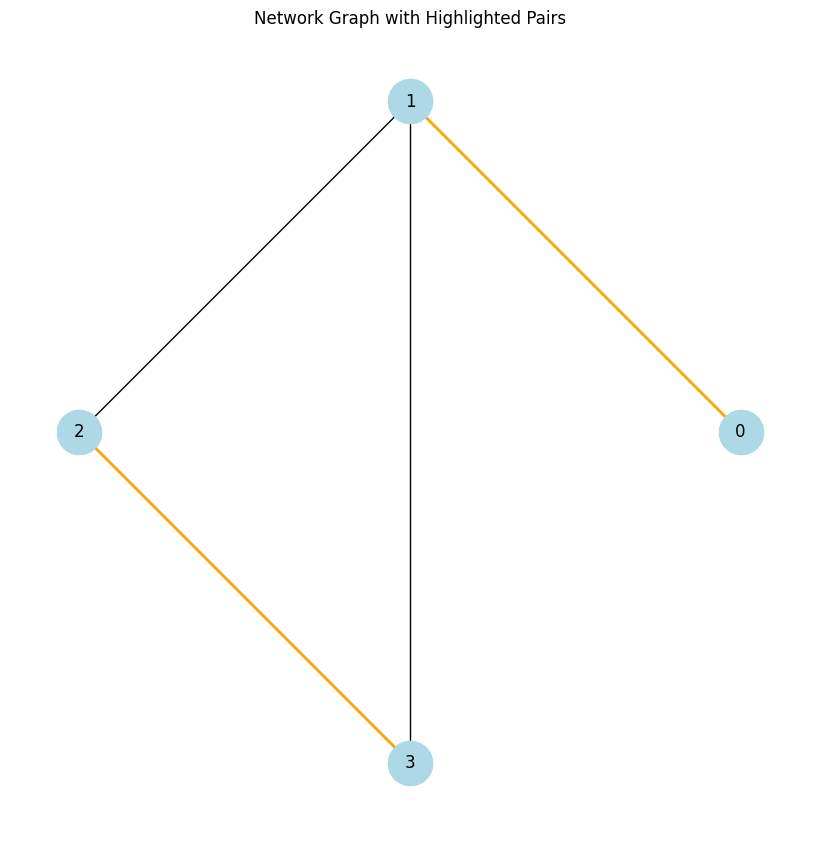

In [37]:
# Example adjacency matrix (0 indicates no connection, 1 indicates connection)
#Provide an adjacency matrix of any size and the code will return the possible ways to form K2 subdivisions.
adj_matrix = [
    [0, 1,0,0],
    [1,0,1,1],
    [1,0,0,1],
    [0,1,1,0]

]
#num_pairs should be the K division you want. For two qubit gates we look for K2 subdivisions. 
num_pairs = 2
subgroups = find_two_node_subgroups(adj_matrix, num_pairs)
print("Unique subgroups of pairs as np.array:")
print(subgroups)

plot_adjacency_matrix(adj_matrix)
plot_network_graph(adjacency_matrix)

# Plot the network graph with highlighted pairs
chosen_pairs=[(0, 1),(2, 3)]
plot_network_graph_with_highlight(adj_matrix, chosen_pairs)

In [12]:
#Example 2 with more nodes and links 
# Example adjacency matrix (0 indicates no connection, 1 indicates connection)
adj_matrix = [[0,1,1,0,0,0,0,0,0,0,1,1],
                    [1,0,1,1,0,0,0,0,0,0,0,1],
                    [1,1,0,1,1,0,0,0,0,0,0,0],
                    [0,1,1,0,1,1,0,0,0,0,0,0],
                    [0,0,1,1,0,1,1,0,0,0,0,0],
                    [0,0,0,1,1,0,1,1,0,0,0,0],
                    [0,0,0,0,1,1,0,1,1,0,0,0],
                    [0,0,0,0,0,1,1,0,1,1,0,0],
                    [0,0,0,0,0,0,1,1,0,1,1,0],
                    [0,0,0,0,0,0,0,1,1,0,1,1],
                    [1,0,0,0,0,0,0,0,1,1,0,1],
                    [1,1,0,0,0,0,0,0,0,1,1,0]]


# Find all possible combinations of two-node connected subgroups
num_pairs = 6
subgroups = find_two_node_subgroups(adj_matrix, num_pairs)
print("Unique subgroups of pairs as np.array:")
print(subgroups)
print(len(subgroups))

Unique subgroups of pairs as np.array:
[array([[10, 11],
       [ 6,  7],
       [ 4,  5],
       [ 0,  2],
       [ 8,  9],
       [ 1,  3]]), array([[ 9, 10],
       [ 1,  2],
       [ 3,  4],
       [ 0, 11],
       [ 5,  6],
       [ 7,  8]]), array([[ 1,  2],
       [ 3,  4],
       [ 8, 10],
       [ 7,  9],
       [ 5,  6],
       [ 0, 11]]), array([[ 8, 10],
       [ 6,  7],
       [ 4,  5],
       [ 0,  2],
       [ 9, 11],
       [ 1,  3]]), array([[ 9, 10],
       [ 2,  4],
       [ 6,  8],
       [ 5,  7],
       [ 1,  3],
       [ 0, 11]]), array([[ 0,  1],
       [ 2,  4],
       [10, 11],
       [ 6,  8],
       [ 7,  9],
       [ 3,  5]]), array([[ 0,  1],
       [ 4,  6],
       [ 8, 10],
       [ 5,  7],
       [ 2,  3],
       [ 9, 11]]), array([[ 2,  4],
       [ 0, 10],
       [ 5,  6],
       [ 9, 11],
       [ 1,  3],
       [ 7,  8]]), array([[ 0, 10],
       [ 1, 11],
       [ 2,  3],
       [ 6,  7],
       [ 4,  5],
       [ 8,  9]]), array([[ 9, 10],
       

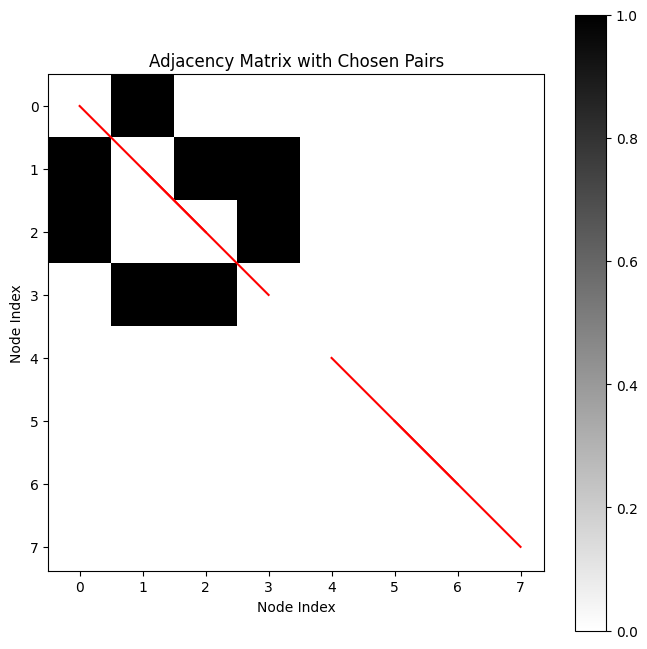

In [38]:
chosen_pairs =[(0, 2), (4, 6), (1, 3), (5, 7)]
plot_chosen_pairs(adj_matrix, chosen_pairs)

In [ ]:
#Example code for finding random qubit pairings 
n=6
objects = list(range(n))
unique_pairs = generate_pairs(objects)

# Output the result
#print(f"Number of unique ways to form pairs: {len(unique_pairs)}")
len(unique_pairs)

# If you want to save the pairings as a file-> specify file name
file_name = 'pairs.txt'

# Open the file in write mode
with open(file_name, 'w') as file:
    for i, array in enumerate(unique_pairs):
        # Write array to file
        #uncomment if you want to save
        #np.savetxt(file, array, fmt='%d')
        # Add a separator between arrays
        
        file.write('\n---\n')

print(f"List of arrays saved to {file_name}")

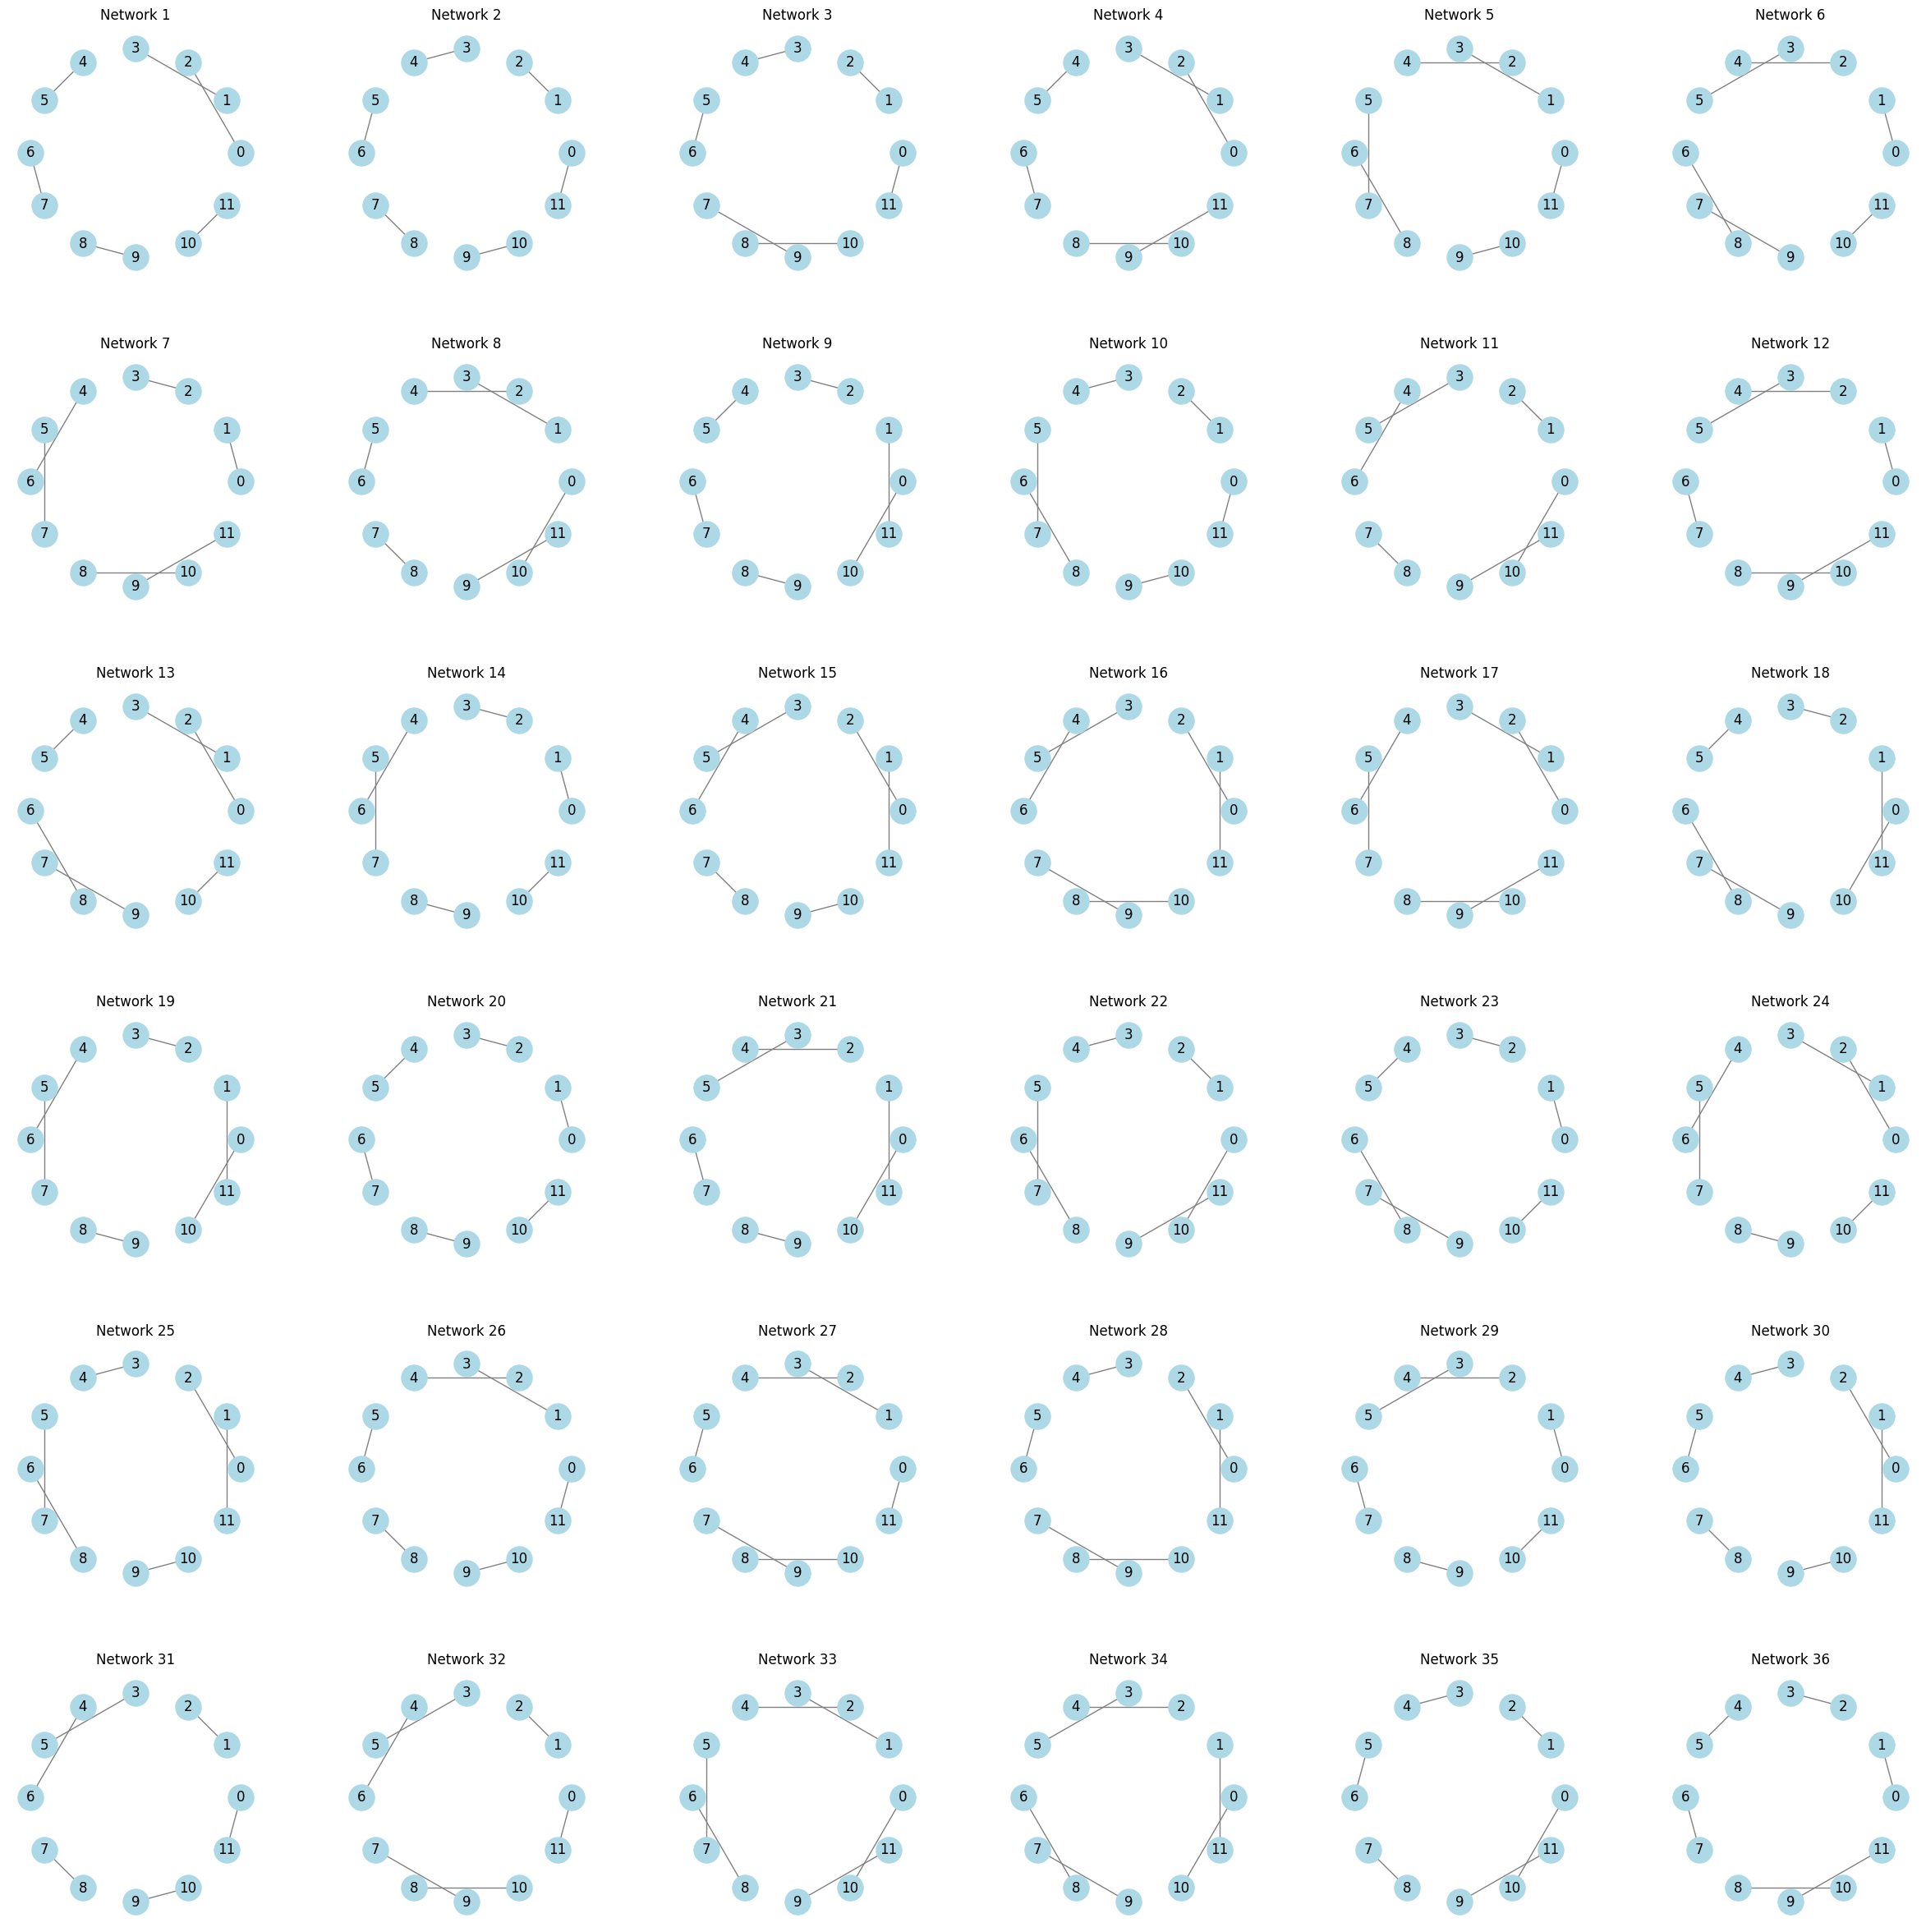

In [15]:
#Visualizing the various K2 subdivisions

list_of_pairs = subgroups
#Make rows and columns of the subplots match the number of pairs. For the above adj matrix that 36 configurations, hence 6x6
#nxm=6x6
n=6
m=6
fig, axes = plt.subplots(n, m, figsize=(30, 30))
fig.subplots_adjust(wspace=0.3, hspace=0.3)

# Function to visualize a graph from a list of pairs
def visualize_network(pairs, ax, title):
    G = nx.Graph()
    G.add_edges_from(pairs)
    node_order = list(range(12))

# Calculate positions for each node in a circle
    angle = 2 * np.pi / len(node_order)
    pos = {node: (np.cos(i * angle), np.sin(i * angle)) for i, node in enumerate(node_order)}
    # Draw the graph
    nx.draw(G, pos, with_labels=True, node_color='lightblue', 
            node_size=500, edge_color='gray', ax=ax)
    ax.set_title(title, fontsize=12)

# Plot each network in the grid
for idx, ax in enumerate(axes.flat):
    if idx < len(list_of_pairs):
        visualize_network(list_of_pairs[idx], ax, f"Network {idx + 1}")
    else:
        ax.axis('off') 

#uncomment the code below if you want to save image. 
#dpi is "dots per inch" and just refers to resolution
#tight means the saved figure does not have any white space
#plt.savefig("Connectivities.png",dpi=300, bbox_inches="tight")
plt.show()

Pair (np.int64(10), np.int64(11)) appears 8 times
Pair (np.int64(6), np.int64(7)) appears 8 times
Pair (np.int64(4), np.int64(5)) appears 8 times
Pair (np.int64(0), np.int64(2)) appears 10 times
Pair (np.int64(8), np.int64(9)) appears 8 times
Pair (np.int64(1), np.int64(3)) appears 10 times
Pair (np.int64(9), np.int64(10)) appears 8 times
Pair (np.int64(1), np.int64(2)) appears 8 times
Pair (np.int64(3), np.int64(4)) appears 8 times
Pair (np.int64(0), np.int64(11)) appears 8 times
Pair (np.int64(5), np.int64(6)) appears 8 times
Pair (np.int64(7), np.int64(8)) appears 8 times
Pair (np.int64(8), np.int64(10)) appears 10 times
Pair (np.int64(7), np.int64(9)) appears 10 times
Pair (np.int64(9), np.int64(11)) appears 10 times
Pair (np.int64(2), np.int64(4)) appears 10 times
Pair (np.int64(6), np.int64(8)) appears 10 times
Pair (np.int64(5), np.int64(7)) appears 10 times
Pair (np.int64(0), np.int64(1)) appears 8 times
Pair (np.int64(3), np.int64(5)) appears 10 times
Pair (np.int64(4), np.int

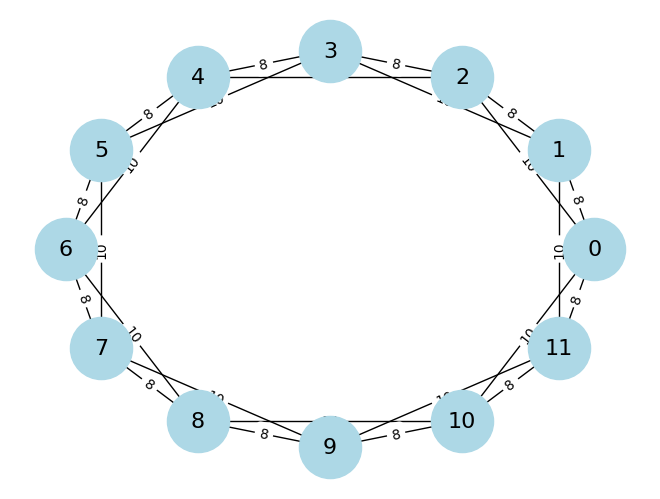

Edges with weights:
(np.int64(10), np.int64(11), {'weight': 8})
(np.int64(10), np.int64(9), {'weight': 8})
(np.int64(10), np.int64(8), {'weight': 10})
(np.int64(10), np.int64(0), {'weight': 10})
(np.int64(11), np.int64(0), {'weight': 8})
(np.int64(11), np.int64(9), {'weight': 10})
(np.int64(11), np.int64(1), {'weight': 10})
(np.int64(6), np.int64(7), {'weight': 8})
(np.int64(6), np.int64(5), {'weight': 8})
(np.int64(6), np.int64(8), {'weight': 10})
(np.int64(6), np.int64(4), {'weight': 10})
(np.int64(7), np.int64(8), {'weight': 8})
(np.int64(7), np.int64(9), {'weight': 10})
(np.int64(7), np.int64(5), {'weight': 10})
(np.int64(4), np.int64(5), {'weight': 8})
(np.int64(4), np.int64(3), {'weight': 8})
(np.int64(4), np.int64(2), {'weight': 10})
(np.int64(5), np.int64(3), {'weight': 10})
(np.int64(0), np.int64(2), {'weight': 10})
(np.int64(0), np.int64(1), {'weight': 8})
(np.int64(2), np.int64(1), {'weight': 8})
(np.int64(2), np.int64(3), {'weight': 8})
(np.int64(8), np.int64(9), {'weight':

In [18]:
#Code to generate how many times a particular pair of nodes are paired up across all the K2 subdivisions. 
#This code shows why for nnext to nearest neighbour connectivity the number of K2 subdivisions that include nearest neighbour nodes is different from that for next to nearest neighbour

# Example list of lists
list_of_pairs = subgroups

# Flatten the list of lists and normalize pairs to always have smaller number first for consistency
pairs = [tuple(sorted(pair)) for sublist in list_of_pairs for pair in sublist]

# Count the occurrences of each pair
pair_counts = Counter(pairs)

# Print the counts
for pair, count in pair_counts.items():
    print(f"Pair {pair} appears {count} times")

# Create a graph
G = nx.Graph()

# Add edges to the graph with the count as the weight
for pair, count in pair_counts.items():
    G.add_edge(pair[0], pair[1], weight=count)

# Get sorted list of nodes
nodes = sorted(G.nodes())
node_index = {node: i for i, node in enumerate(nodes)}

# Create adjacency matrix
adj_matrix = np.zeros((len(nodes), len(nodes)))

for (u, v, data) in G.edges(data=True):
    adj_matrix[node_index[u], node_index[v]] = data["weight"]
    adj_matrix[node_index[v], node_index[u]] = data["weight"]  # Since it's an undirected graph

print("Adjacency Matrix:")
print(adj_matrix)

# uncomment if you want to save the adjacency matrix for further computation as a txt file
#np.savetxt("adjacency_matrix.txt", adj_matrix, fmt="%d")

# Draw the graph
# Specify the desired node order (0, 1, 2, ..., 7)
node_order = list(range(12))

# Calculate positions for each node in a circle
angle = 2 * np.pi / len(node_order)
pos = {node: (np.cos(i * angle), np.sin(i * angle)) for i, node in enumerate(node_order)}

nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, font_size=16)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

#Uncomment if you want to save the figure 
#dpi is "dots per inch" and just refers to resolution
#tight means the saved figure does not have any white space
#plt.savefig("frequency_of_pairings.png",dpi=300, bbox_inches='tight')
plt.show()

# Optionally print the edges and their weights
print("Edges with weights:")
for edge in G.edges(data=True):
    print(edge)